In [12]:
# import libraries

import bok_python as bp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 베이지안 회귀분석

## 구성 함수
* Bayes_gen_hyper: 하이퍼 파라미터 생성 함수
* Bayes_sample_beta: beta 샘플링 함수
* Bayes_sample_sig2: sig2 샘플링 함수
* Bayes_sample_gam: gamma 샘플링 함수
* Bayes_sample_b_: b0, b1 샘플링 함수
* Bayes_result_table: 추정 결과 테이블 출력 함수
* Bayes_var: 베이지안 R2를 위한 variance 계산 함수
* Bayes_R2: 베이지안 R2 계산 함수
* Bayes_Gibbs_VS: 베이지안 변수선택(Bayesian Variable Selection) 함수
* Bayes_Gibbs_LIN: 베이지안 선형회귀(Bayesian Linear Regression) 함수
* Bayes_histogram: 히스토그램 그래프 출력 함수

## 베이지안 선형회귀

### 모형
* $\sigma^{2} \sim IG(\frac{\alpha_{0}}{2}, \frac{\delta_{0}}{2}) \\$
* $\beta \sim Normal(\beta_{0}, B_{0}) \\$
* $Y|\beta, \sigma^{2} \sim Normal(X\beta, \sigma^{2}I_{T}) \\$


### 기본 하이퍼-파라미터
* 샘플링 크기
    * $n$: 깁스-샘플링 크기
    * $n_{0}$: 번인(burn-in) 크기
    * $n_{1}=n-n_{0}$: 사후분포 추론에 사용할 샘플링 크기

* $\beta$ 관련 하이퍼-파라미터 디폴트값
    * $\beta_{0}=0 \\$
    * $B_{0}=25 \\$

* $\sigma^{2}$ 관련 하이퍼-파라미터 디폴트값
    * $\alpha_{0}=5 \\$
    * $\delta_{0}=5 \\$

In [13]:
hyper = bp.Bayes_gen_hyper()

## 만약 하이퍼-파라미터를 변경하고 싶다면...
# 예1) sig2 의 하이퍼 파라미터 변경 시
hyper['alpha0'] = 10
hyper['delta0'] = 10
hyper['sig2'] = hyper['alpha0']/hyper['delta0'] # 사전 평균도 다시 계산해야 한다.

# 예2) 깁스-샘플링 크기 변경 시
hyper['n1'] = 20000
hyper['n0'] = int(hyper['n1'] * 0.1) # int 는 오류 방지를 위해 붙일 것을 권장한다.
hyper['n'] = hyper['n0'] + hyper['n1']

### 코드 실습

* 데이터를 불러와서 코드를 실습한다.
* 실습 데이터: 한국 GDP, CPI, M2, 국고채 10년, 미국 10년물 금리

### 1) 자료 불러오기

In [14]:
# 데이터프레임 형태로 데이터 불러오기
df = pd.read_excel("./test_data/bayes_test_data.xlsx")
df

,krgdp_qoq,krgdp1_qoq,krcpi_qoq,krm2_qoq,kr10y,us10y
0,-0.324985,2.717335,0.659799,1.417791,7.760,5.12
1,1.218106,-0.324985,1.766167,1.752773,6.690,4.93
2,1.290518,1.218106,1.157815,2.339417,7.490,5.42
3,1.341160,1.290518,0.574675,4.178410,6.440,4.60
4,1.747232,1.341160,-0.254330,-0.487594,6.810,5.07
...,...,...,...,...,...,...
87,0.233454,0.747667,1.128388,0.938318,3.497,3.83
88,-0.303428,0.233454,0.394695,0.276973,3.890,3.88
89,0.329332,-0.303428,1.047989,0.496197,3.437,3.48
90,0.606808,0.329332,0.641578,0.824358,3.447,3.81


### 2) 최소옵션
- Beta, Sigma2, R2 = bp.Bayes_Gibbs_LIN(종속변수, 독립변수, 하이퍼파라미터, 표 표시 여부)

In [15]:
# 변수 지정
Y = np.matrix(df[['krgdp_qoq']]) # 종속변수
X = np.matrix(df[['krgdp1_qoq', 'krcpi_qoq', 'krm2_qoq', 'kr10y', 'us10y']]) # 독립변수

T, K = Y.shape
hyper = bp.Bayes_gen_hyper()

## 일반적인 베이지안 선형회귀 결과
Betam, Sig2m, R2m = bp.Bayes_Gibbs_LIN(Y[0:T-1], X[0:T-1], hyper)

Coefficients: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.105161  0.105007  0.107148 -0.070370  0.285253
var2  0.308369  0.309179  0.181976  0.007836  0.607974
var3  0.035384  0.035089  0.081727 -0.099080  0.170632
var4 -0.108330 -0.107390  0.113748 -0.295547  0.077856
var5  0.299499  0.300352  0.143186  0.062680  0.535245
R2: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.379888  0.379246  0.035699  0.322403  0.438732


In [16]:
# CI 범위를 [0.025, 0.975]로 하고 싶을 경우
# Betam, Sig2m, R2m = bp.Bayes_Gibbs_LIN(Y[0:99], X[0:99], hyper, display=1, quantile=[0.025, 0.975])
# 와 같은 방식도 지원하나, 
# 동일 추정에서 CI만 다르게 보고 싶은 경우 아래처럼 표만 따로 출력하는 것도 가능하다
# 또한 결과는 dataframe 형태로 저장되며 excel 형태로 밖으로 내보낼 수 있다. 

result = bp.Bayes_result_table(Betam, [0.025, 0.975])

          Mean    Median      S.E.    0.025%    0.975%
var1  0.105161  0.105007  0.107148 -0.104625  0.317908
var2  0.308369  0.309179  0.181976 -0.049106  0.667611
var3  0.035384  0.035089  0.081727 -0.125111  0.197268
var4 -0.108330 -0.107390  0.113748 -0.329070  0.115661
var5  0.299499  0.300352  0.143186  0.015612  0.583533


### 3) 예측분포 함께 출력
- Beta, Sigma2, R2, Yf(예측분포) = bp.Bayes_Gibbs_LIN(종속변수, 독립변수, 하이퍼파라미터, 예측에 사용될 독립변수)

In [17]:
## Out-Of-Sample Forecasting(표본 외 예측)을 원할 경우 X의 실현값을 함께 입력하면
## Yfm(예측 분포)이 함께 출력된다.

Betam, Sig2m, R2m, Yfm = bp.Bayes_Gibbs_LIN(Y[0:T-1], X[0:T-1], hyper, X[T-1:T])

Coefficients: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.104665  0.104173  0.107252 -0.070548  0.281980
var2  0.306475  0.306011  0.184399  0.002134  0.611896
var3  0.036107  0.036418  0.081126 -0.097785  0.167727
var4 -0.107162 -0.107095  0.112563 -0.289910  0.079366
var5  0.298269  0.298112  0.141124  0.067536  0.529868
R2: 
         Mean    Median      S.E.     0.05%     0.95%
var1  0.37955  0.378982  0.035922  0.321347  0.438753
Forecast: 
          Mean    Median      S.E.     0.05%     0.95%
var1  1.354508  1.358356  0.930645 -0.160176  2.900225


### 4) PPL 함께 출력
- Beta, Sigma2, R2, Yf, lnPPL = bp.Bayes_Gibbs_LIN(종속변수, 독립변수, 하이퍼파라미터, 독립변수 실현값, 종속변수 실현값)

In [18]:
## Out-Of-Sample Forecasting(표본 외 예측)을 통해 튜닝을 원할 경우
## 아래와 같이 X, Y의 실현값(XT1, YT1)을 모두 입력하면 로그PPL이 함께 계산된다.

Betam, Sig2m, R2m, Yfm, lnPPD = bp.Bayes_Gibbs_LIN(Y[0:T-1], X[0:T-1], hyper, X[T-1:T], Y[T-1:T])

Coefficients: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.103337  0.102890  0.107004 -0.072421  0.280204
var2  0.306042  0.307352  0.183093  0.009262  0.603695
var3  0.036301  0.036202  0.082944 -0.100071  0.172989
var4 -0.107419 -0.107835  0.114278 -0.295352  0.080169
var5  0.298476  0.299164  0.142879  0.064285  0.533162
R2: 
          Mean   Median      S.E.     0.05%    0.95%
var1  0.379902  0.37919  0.035622  0.322203  0.44075
Forecast: 
          Mean    Median      S.E.    0.05%     0.95%
var1  1.355616  1.353117  0.935781 -0.17199  2.912618
log PPD:  -1.1688943505865552


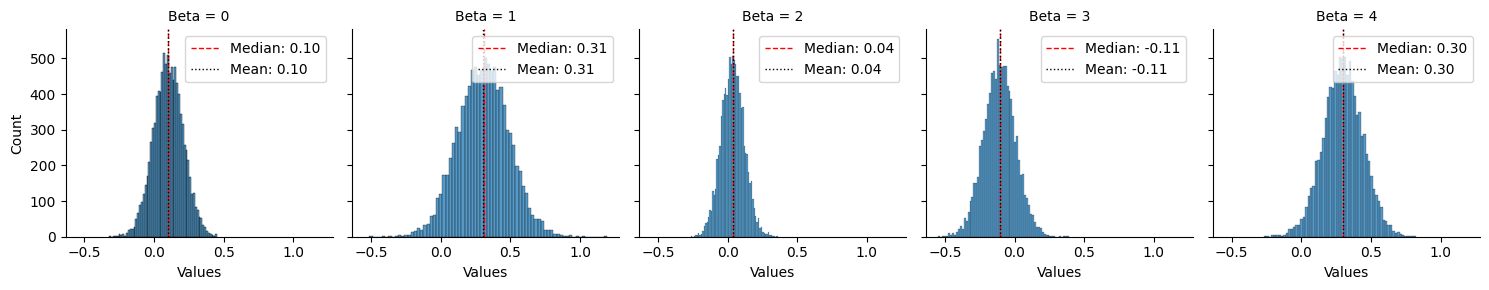

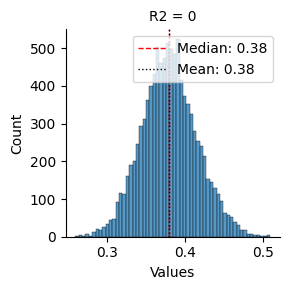

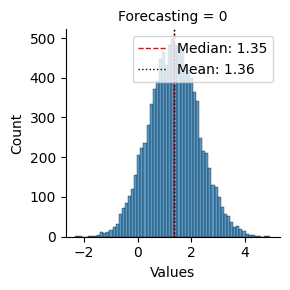

In [19]:
## 결과 그래프 출력
bp.Bayes_histogram(Betam, "Beta")
bp.Bayes_histogram(R2m, "R2")
bp.Bayes_histogram(Yfm, "Forecasting")

## 베이지안 변수선택

### 모형
* $p \sim Beta(a_{0}, c_{0}) \\$
* $Pr[\gamma_{k}=1|p] = p, Pr[\gamma_{k}=0|p]= 1-p \ \ for \ k=1,2,..,K \\$
* $b_{0} \sim IG(\frac{\alpha_{00}}{2}, \frac{\delta_{00}}{2}) \\$
* $b_{0} \sim IG(\frac{\alpha_{01}}{2}, \frac{\delta_{01}}{2}) \\$

* $\beta_{k}|\gamma_{k}, b_{0}, b_{1} \sim Normal(0, \gamma_{k}b_{1} + (1-\gamma_{k})b_{0}) \\$
    * $\beta = (\beta_{1}, \beta{2}, .., \beta_{K}) $
* $\sigma^{2} \sim IG(\frac{\alpha_{0}}{2}, \frac{\delta_{0}}{2}) \\$


### 기본 하이퍼-파라미터
* 샘플링 크기
    * $n$: 깁스-샘플링 크기
    * $n_{0}$: 번인(burn-in) 크기
    * $n_{1}=n-n_{0} \\$

* $\sigma^{2}$ 하이퍼-파라미터
    * $\alpha_{0}=5 \\$
    * $\delta_{0}=5 \\$
    * $\mathbb{E}[\sigma^{2}] = \frac{\delta_{0}}{\alpha_{0}}$

* $p$ 하이퍼-파라미터
    * $a_{0} = 10$
    * $c_{0} = 10$
    * $\mathbb{E}[p] = \frac{c_{0}}{c_{0} + a_{0}}$

* $b_{0}$ 하이퍼-파라미터
    * $\alpha_{00} = 20$
    * $\delta_{00} = \alpha_{00} * 0.0001$
    * $\mathbb{E}[b_{0}] = \frac{\delta_{00}}{\alpha_{00}}$

* $b_{1}$ 하이퍼-파라미터
    * $\alpha_{01} = 20$
    * $\delta_{01} = \alpha_{00} * 10$
    * $\mathbb{E}[b_{1}] = \frac{\delta_{01}}{\alpha_{01}}$

### 1) 데이터 전처리
- 앞과 동일

### 2) 최소 옵션
- Beta, Sigma2, Gamma, P, R2 = bp.Bayes_Gibbs_VS(종속변수, 독립변수, 하이퍼파라미터)

In [20]:
# 앞과 동일한 데이터로 추정

# 하이퍼-파라미터 생성
hyper = bp.Bayes_gen_hyper("VS") # 'VS' 입력
Betam, Sig2m, Gamm, Pm, R2m = bp.Bayes_Gibbs_VS(Y[0:T-1], X[0:T-1], hyper)

Coefficients: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.005661  0.001183  0.033490 -0.016830  0.025831
var2  0.042709  0.002887  0.121956 -0.015402  0.361269
var3  0.002338  0.001019  0.019126 -0.016512  0.019939
var4  0.005859  0.000173  0.048221 -0.020081  0.044661
var5  0.251980  0.262335  0.073193  0.125801  0.326750
R2: 
          Mean   Median      S.E.     0.05%     0.95%
var1  0.366829  0.36607  0.035149  0.309394  0.425539


### 3) 예측분포 함께 출력
- Beta, Sigma2, Gamma, P, R2, Yf(예측분포) = bp.Bayes_Gibbs_VS(종속변수, 독립변수, 하이퍼파라미터, 예측에 사용될 독립변수)

In [21]:
# 예측 분포도 함께

Betam, Sig2m, Gamm, Pm, R2m, Yfm = bp.Bayes_Gibbs_VS(Y[0:T-1], X[0:T-1], hyper, X[T-1:T])

Coefficients: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.004637  0.001172  0.030770 -0.016248  0.022289
var2  0.045524  0.003191  0.127216 -0.016733  0.366626
var3  0.002301  0.000921  0.018715 -0.017093  0.020508
var4  0.000855 -0.000604  0.039250 -0.021164  0.020784
var5  0.259021  0.265267  0.063989  0.164484  0.327523
R2: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.367163  0.366945  0.034836  0.311442  0.424959
Forecast: 
          Mean    Median      S.E.     0.05%     0.95%
var1  1.229441  1.225847  0.902438 -0.253681  2.712015


### 4) PPL 함께 출력
- Beta, Sigma2, Gamma, P, R2, Yf, lnPPL = bp.Bayes_Gibbs_VS(종속변수, 독립변수, 하이퍼파라미터, 독립변수 실현값, 종속변수 실현값)

In [22]:
# 로그 PPL 도 함께

Betam, Sig2m, Gamm, Pm, R2m, Yfm, lnPPD = bp.Bayes_Gibbs_VS(Y[0:T-1], X[0:T-1], hyper, X[T-1:T], Y[T-1:T])

Coefficients: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.005365  0.001287  0.032355 -0.016568  0.024934
var2  0.043287  0.002791  0.124327 -0.016438  0.363069
var3  0.002354  0.001139  0.017457 -0.015976  0.020077
var4  0.007794  0.000006  0.049628 -0.020007  0.135212
var5  0.249849  0.263306  0.075389  0.016030  0.326061
R2: 
          Mean    Median      S.E.     0.05%     0.95%
var1  0.366136  0.365405  0.034803  0.310026  0.424975
Forecast: 
          Mean    Median     S.E.    0.05%     0.95%
var1  1.237887  1.231369  0.91021 -0.26016  2.708793
log PPD:  -1.0527864406510952


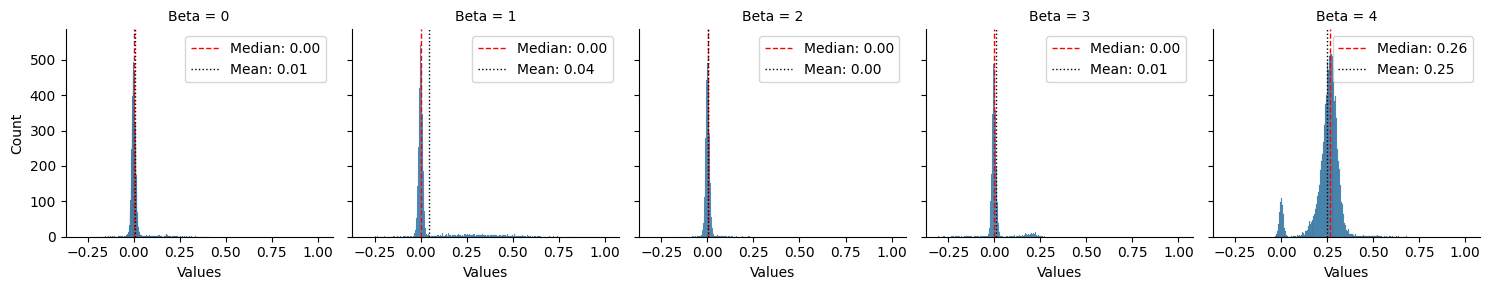

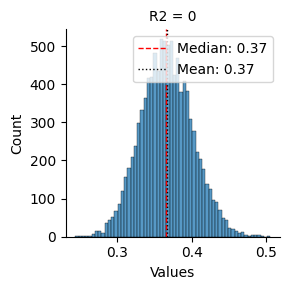

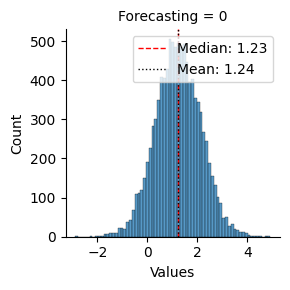

In [23]:
## 결과 그래프 출력
bp.Bayes_histogram(Betam, "Beta")
bp.Bayes_histogram(R2m, "R2")
bp.Bayes_histogram(Yfm, "Forecasting")

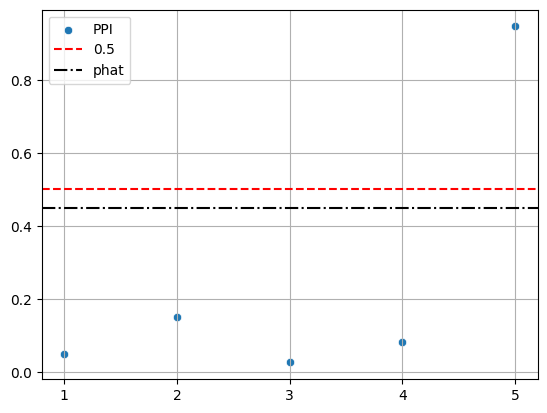

In [24]:
# 각 변수의 PPI 그래프 그리기
bp.Bayes_scatter(Gamm, Pm, "PPI")